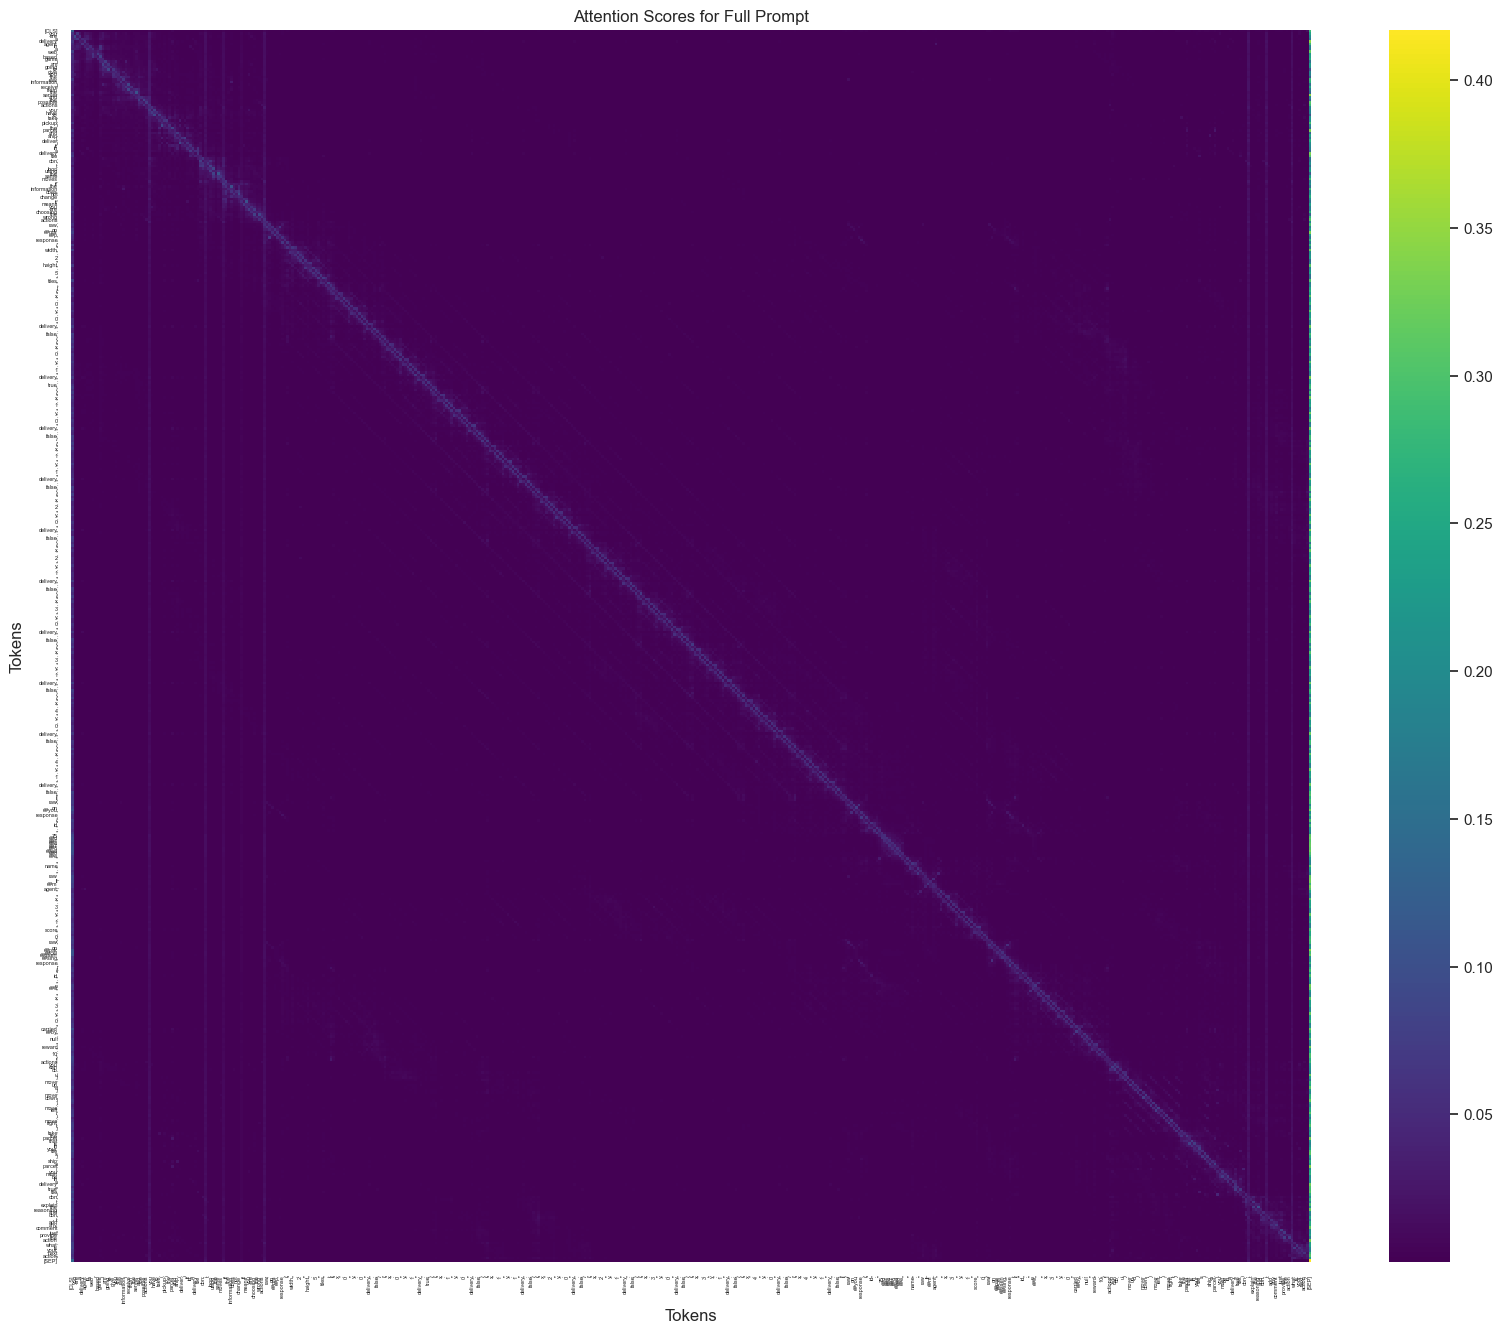

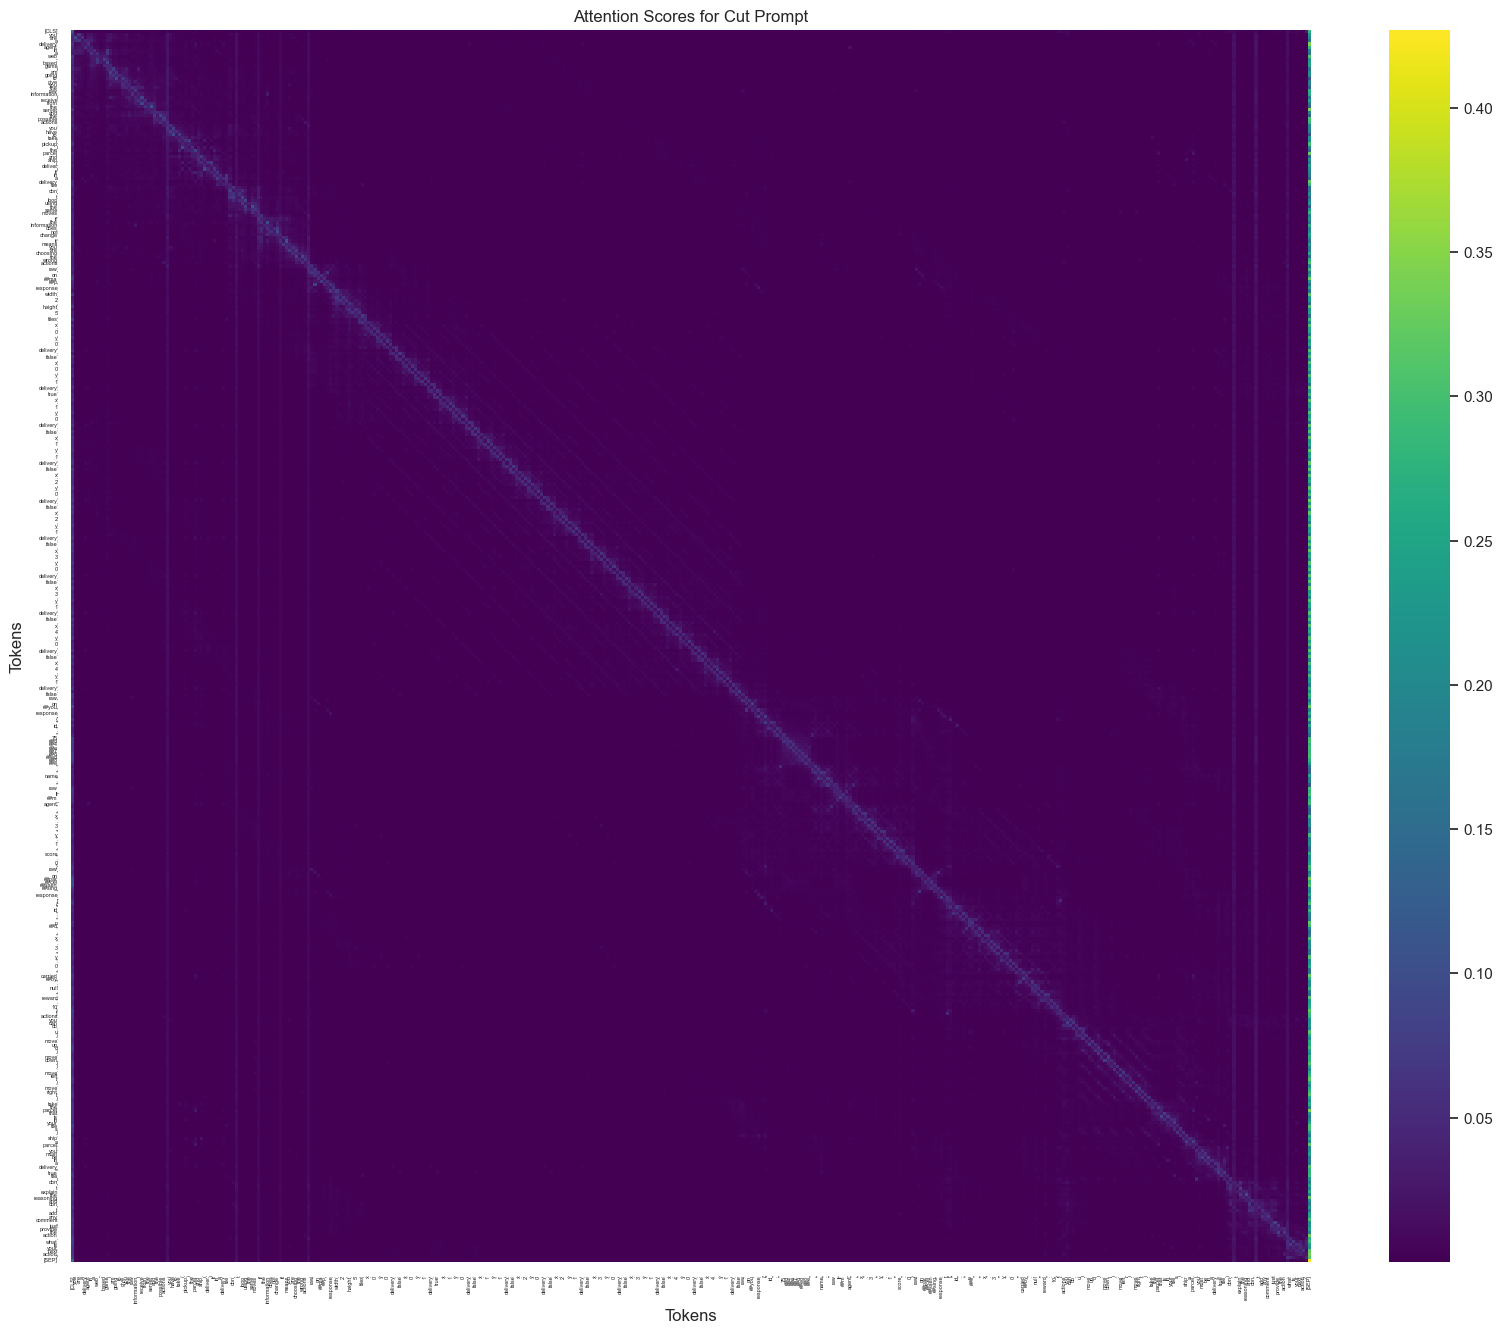

Top 20 tokens for full prompt (weighted sum):
[SEP]
[CLS]
'
.
'
.
.
'
.
,
game
=
.
?
reasoning
parcel
parcel
score
response
{
[
parcel
{
tile
i
{
if
you
response
{
[
{
loop
comment
}
information
actions
{
{
{
and
{
ship
and
server
{
you
choosing
using
}

Top 20 tokens for cut prompt (weighted sum):
[SEP]
[CLS]
'
'
.
.
'
.
.
,
game
{
{
=
.
}
parcel
[
reasoning
i
actions
you
if
parcel
moves
height
width
score
]
ship
tile
loop
information
choosing
you
pickup
and
you
parcel
and
)
server
}
information
and
ship
explain
using
reward
name


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the text files
with open('promptFull.txt', 'r') as file:
    prompt_full = file.read()

with open('prompt.txt', 'r') as file:
    prompt_cut = file.read()

# Load a pre-trained model and tokenizer
model_name = 'bert-base-uncased'  # You can choose any model you prefer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Tokenize the prompts
inputs_full = tokenizer(prompt_full, return_tensors='pt')
inputs_cut = tokenizer(prompt_cut, return_tensors='pt')

# Get the attention scores
with torch.no_grad():
    outputs_full = model(**inputs_full)
    outputs_cut = model(**inputs_cut)

# Extract attention scores
attentions_full = outputs_full.attentions
attentions_cut = outputs_cut.attentions

# Average the attention scores across all heads, layers, and batch
avg_attentions_full = torch.mean(torch.stack(attentions_full), dim=(0, 1, 2)).squeeze()
avg_attentions_cut = torch.mean(torch.stack(attentions_cut), dim=(0, 1, 2)).squeeze()

# Plot the attention scores
def plot_attention(attentions, tokens, title):
    sns.set(style='whitegrid')
    plt.figure(figsize=(20, 16))
    sns.heatmap(attentions, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(title)
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    plt.show()

# Get the tokens
tokens_full = tokenizer.convert_ids_to_tokens(inputs_full['input_ids'].squeeze())
tokens_cut = tokenizer.convert_ids_to_tokens(inputs_cut['input_ids'].squeeze())

# Plot the attention for full and cut prompts
plot_attention(avg_attentions_full, tokens_full, 'Attention Scores for Full Prompt')
plot_attention(avg_attentions_cut, tokens_cut, 'Attention Scores for Cut Prompt')


# Calculate the sum of attention for each token
sum_attentions_full = torch.sum(avg_attentions_full, dim=0)
sum_attentions_cut = torch.sum(avg_attentions_cut, dim=0)

# Get the top 20 tokens by weighted attention for both full and cut prompts
top_tokens_full = sorted(zip(tokens_full, sum_attentions_full.tolist()), key=lambda x: x[1], reverse=True)[:50]
top_tokens_cut = sorted(zip(tokens_cut, sum_attentions_cut.tolist()), key=lambda x: x[1], reverse=True)[:50]

print("Top 20 tokens for full prompt (weighted sum):")
for token, attention in top_tokens_full:
    print(f"{token}")

print("\nTop 20 tokens for cut prompt (weighted sum):")
for token, attention in top_tokens_cut:
    print(f"{token}")

In [43]:
def plot_attention(attentions, tokens, title):
    sns.set(style='whitegrid')
    plt.figure(figsize=(40, 32))
    sns.heatmap(attentions, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(title)
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

Full Reduced Tokens Length: 264
Cut Reduced Tokens Length: 264
Full Reduced Attention Shape: torch.Size([264, 264])
Cut Reduced Attention Shape: torch.Size([264, 264])


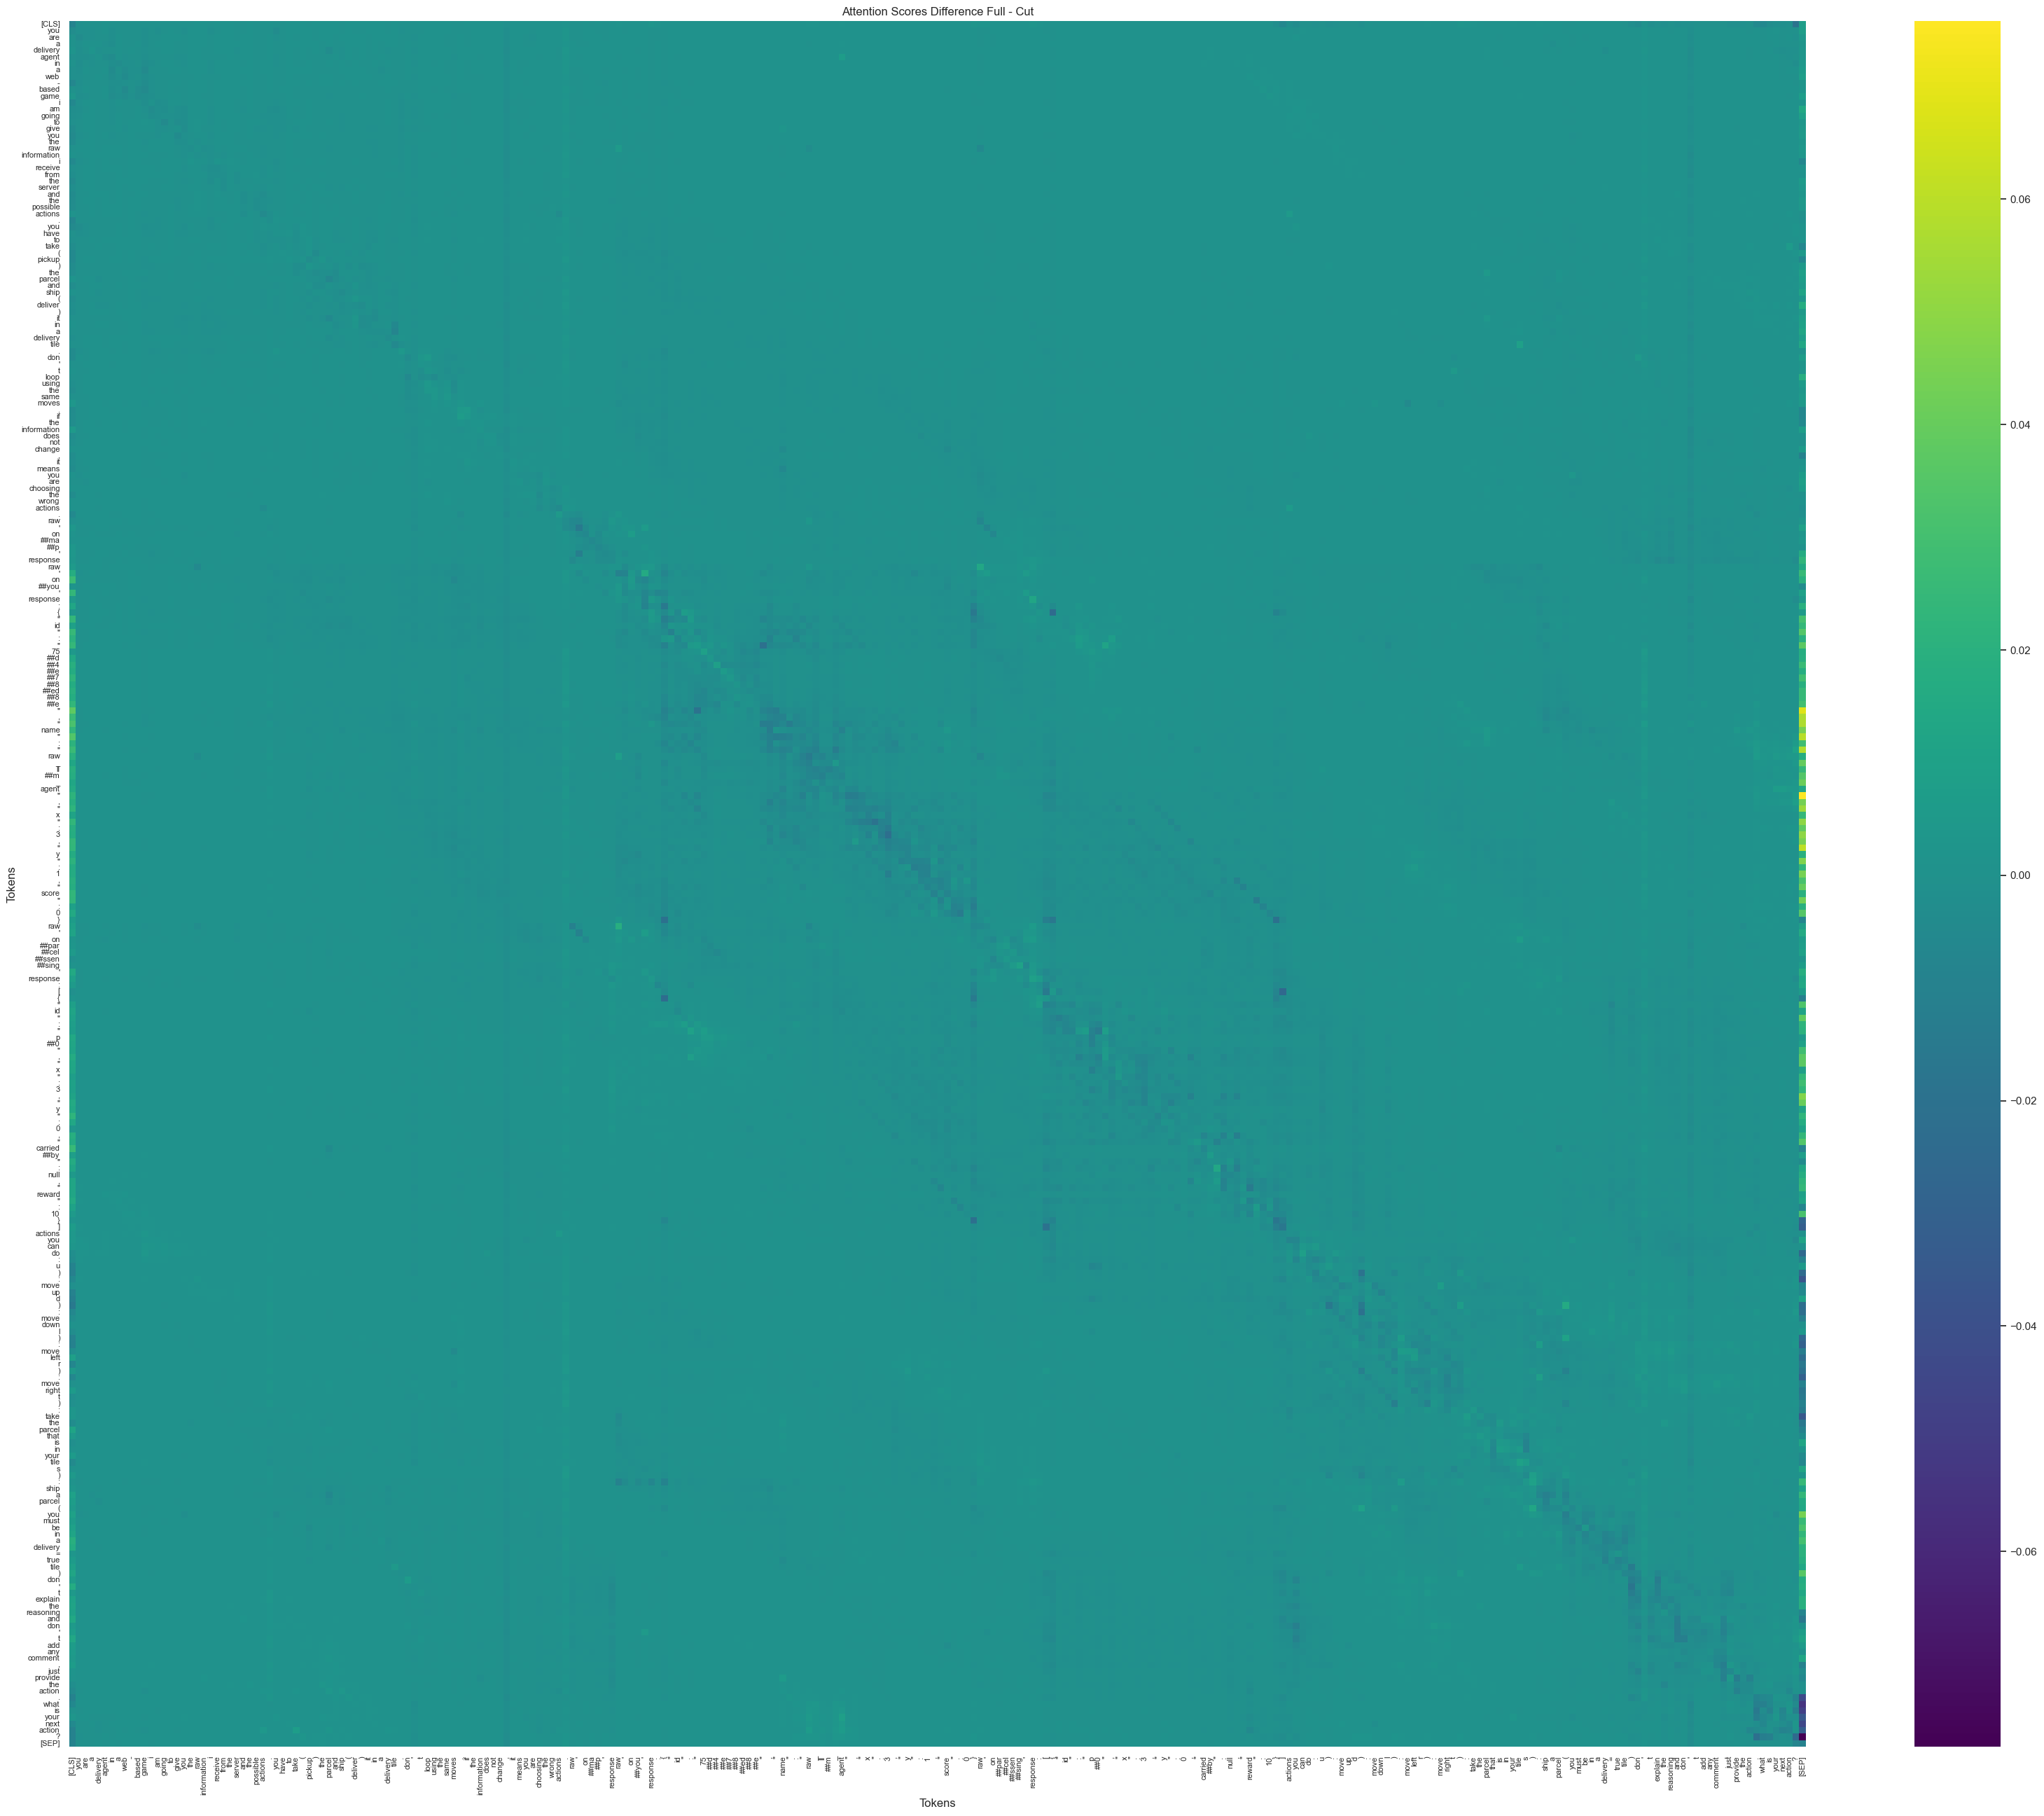

In [44]:
# Define removal indices
start_i_to_remove = 83
end_i_to_remove_full_included = 303
end_i_to_remove_cut_included = 213

# Create index lists for tokens to keep (common tokens at the start and the end)
rows_full = list(range(0, start_i_to_remove)) + list(range(end_i_to_remove_full_included, len(tokens_full)))
rows_cut = list(range(0, start_i_to_remove)) + list(range(end_i_to_remove_cut_included, len(tokens_cut)))

# Build reduced token lists
tokens_full_reduced = [tokens_full[i] for i in rows_full]
tokens_cut_reduced = [tokens_cut[i] for i in rows_cut]

# Verify that the token lists match in length
print("Full Reduced Tokens Length:", len(tokens_full_reduced))
print("Cut Reduced Tokens Length:", len(tokens_cut_reduced))

# Slice the attention matrices along both dimensions using the same indices
avg_attentions_full_reduced = avg_attentions_full[rows_full][:, rows_full]
avg_attentions_cut_reduced = avg_attentions_cut[rows_cut][:, rows_cut]

# Verify the shapes now match
print("Full Reduced Attention Shape:", avg_attentions_full_reduced.shape)
print("Cut Reduced Attention Shape:", avg_attentions_cut_reduced.shape)

if avg_attentions_full_reduced.shape != avg_attentions_cut_reduced.shape:
    raise ValueError("Shape mismatch after slicing! Check your indices.")

# Plot the attention scores for each version
# plot_attention(avg_attentions_full_reduced, tokens_full_reduced, 'Attention Scores for Full Prompt Reduced')
# plot_attention(avg_attentions_cut_reduced, tokens_cut_reduced, 'Attention Scores for Cut Prompt Reduced')

# Compute and plot the difference between the attention scores
diff = avg_attentions_full_reduced - avg_attentions_cut_reduced
plot_attention(diff, tokens_full_reduced, 'Attention Scores Difference Full - Cut')


In [45]:
total_diff_sum = torch.sum(diff).item()
print("Total sum of differences in attention:", total_diff_sum)

Total sum of differences in attention: -15.344758987426758
